# RHLF Pipeline

*Nathan Vidal*


**Outline**

The notebook is built as following:

*   an initialization section (loading librairies, connected to drive account (for storage), and setting torch to cuda)
*   the next two parts consist in loading the model, the tokenization function, the dataset and preprocess the data
* the third section is the training of the reward model (and analyses of the results)
* the final section is the optimization of the model with PPO (and analyses of the results)



## Initialization

In [1]:
!pip install trl
!pip install datasets

In [2]:
import os
import gc
import torch
import numpy as np
import random

from datasets import load_dataset, concatenate_datasets
from torch.utils.data import DataLoader

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoModelForCausalLM,
)

from trl import (
    ModelConfig,
    RewardConfig,
    RewardTrainer,
    ScriptArguments,
    get_peft_config,
    PPOTrainer,
    PPOConfig,
)

from google.colab import drive

In [3]:
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/RLHF'

seed = 17
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


## Load base model and tokenizer

We will use gpt-2 model

In [8]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)
base_model.to(device)
base_model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
#Example
prompt = "Explain reinforcement learning in simple terms."

inputs = tokenizer(prompt, return_tensors="pt").to(device)

with torch.no_grad():
    output_ids = base_model.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=True,
        temperature=0.7,
    )

print(tokenizer.decode(output_ids[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Explain reinforcement learning in simple terms.

"It's an amazing concept, the way you can learn how to do this, and it's very interesting to see how people are surprised at the speed and the enthusiasm. I've never seen anything like it before."

One of


## Loading dataset

We will use the daatset stanfordnlp/explainlikeimfive.
We will tokenize it, keep only 1000 instances under 256 tokens, for computional efficiency.

In [4]:
subreddits = ["explainlikeimfive"] #, "askscience", "askphilosophy"]
datasets_list = []

for sr in subreddits:
    ds = load_dataset("stanfordnlp/shp", data_dir=sr)
    datasets_list.append(ds["train"])

reward_dataset = concatenate_datasets(datasets_list)
print("Dataset size: ",len(reward_dataset))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset size:  19592


In [ ]:
print(reward_dataset[0])


{'post_id': '6efne8', 'domain': 'explainlikeimfive_train', 'upvote_ratio': 0.84, 'history': "Explain like I'm five years old:How after 5000 years of humanity surviving off of bread do we have so many people within the last decade who are entirely allergic to gluten?", 'c_root_id_A': 'di9wmo9', 'c_root_id_B': 'di9zivv', 'created_at_utc_A': 1496245057, 'created_at_utc_B': 1496248218, 'score_A': 2797, 'score_B': 16042, 'human_ref_A': "Just so we're clear: Allergy to gluten is a thing, but is different from celiac disease. Both are well-defined and different from gluten intolerance, which is less clear.   The most common explanation for increased allergies is the hygiene hypothesis. The idea is that aggressive modern hygiene removes the parasites and bacteria that help calibrate the immune system, leaving it more likely to react to harmless targets.  It's also been suggested that modern wheat could be more allergenic. The cross-breeding of new wheat strains in the 1960s, which allowed us t

In [5]:
#Convert to prompt/chosen/rejected format for Reward Model

def to_prompt_chosen_rejected(example):
    #Determine chosen and rejected using labels
    if example["labels"] == 1:
        chosen = example["human_ref_A"]
        rejected = example["human_ref_B"]
    else:
        chosen = example["human_ref_B"]
        rejected = example["human_ref_A"]

    return {
        "prompt": example["history"],
        "chosen": chosen,
        "rejected": rejected
    }


reward_dataset_mapped = reward_dataset.map(to_prompt_chosen_rejected)

columns_to_remove = [
    'post_id', 'upvote_ratio', 'c_root_id_A', 'c_root_id_B',
    'created_at_utc_A', 'created_at_utc_B', 'score_A', 'score_B',
    'human_ref_A', 'human_ref_B', 'seconds_difference', 'score_ratio'
]

reward_dataset_clean = reward_dataset_mapped.remove_columns(columns_to_remove)
print(reward_dataset_clean.column_names)



['domain', 'history', 'labels', 'prompt', 'chosen', 'rejected']


#### Tokenize the dataset

In [6]:
max_length = 256  #Truncate if text is longer than 256 tokens (due to limits in computional capacities)

def tokenize_rm(example):
    # Tokenize prompt
    prompt_tokens = tokenizer(
        example["prompt"],
        max_length=max_length,
        truncation=True,
        padding="max_length"
    )
    # Tokenize chosen response
    chosen_tokens = tokenizer(
        example["prompt"],
        example["chosen"],
        max_length=max_length,
        truncation=True,
        padding="max_length"
    )
    # Tokenize rejected response
    rejected_tokens = tokenizer(
        example["prompt"],
        example["rejected"],
        max_length=max_length,
        truncation=True,
        padding="max_length"
    )

    return {
        "prompt_input_ids": prompt_tokens["input_ids"],
        "prompt_attention_mask": prompt_tokens["attention_mask"],
        "chosen_input_ids": chosen_tokens["input_ids"],
        "chosen_attention_mask": chosen_tokens["attention_mask"],
        "rejected_input_ids": rejected_tokens["input_ids"],
        "rejected_attention_mask": rejected_tokens["attention_mask"]
    }


In [9]:
#Example
reward_dataset_tokenized = reward_dataset_clean.map(tokenize_rm,batched=False,remove_columns=["prompt", "chosen", "rejected"])

print(reward_dataset_tokenized[0])

{'domain': 'explainlikeimfive_train', 'history': "Explain like I'm five years old:How after 5000 years of humanity surviving off of bread do we have so many people within the last decade who are entirely allergic to gluten?", 'labels': 0, 'prompt_input_ids': [18438, 391, 588, 314, 1101, 1936, 812, 1468, 25, 2437, 706, 23336, 812, 286, 9265, 16997, 572, 286, 8509, 466, 356, 423, 523, 867, 661, 1626, 262, 938, 5707, 508, 389, 5000, 31856, 284, 21578, 30, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5025

In [10]:
#Example chosen/rejected
sample = reward_dataset_tokenized[0]

print(tokenizer.decode(sample["chosen_input_ids"]))
print(tokenizer.decode(sample["rejected_input_ids"]))

Explain like I'm five years old:How after 5000 years of humanity surviving off of bread do we have so many people within the last decade who are entirely allergic to gluten?We don't know. There are a number of theories about this. To clarify, while the increase may be exaggerated by people who falsely claim intolerance when they probably have other health issues (or are hypochondriacs), there is actually an increase in people with diagnosable gluten intolerance. And gluten intolerance is different than celiac. I'm taking here about gluten intolerance. Some possible causes include changes in the gut microbiome and changes in how we process and make bread.  Changes in the gut microbiome are a likely cause/contributor but the causes and effects of that are just stating to be understood, and barely. So I won't go into that too much, but if anyone has questions I may be able to answer.  On the processing side, one interesting theory is that the germ of wheat helps us process the gluten in s

In [11]:
#Create the small subdatasets of answers under 256 tokens
pad_id = tokenizer.pad_token_id
def is_under_limit(example):
    actual_content = [t for t in example['chosen_input_ids'] if t != pad_id]
    return len(actual_content) < 256


df_filtered = reward_dataset_tokenized.filter(is_under_limit)

print(f"Original samples: {len(reward_dataset_tokenized)}")
print(f"Samples under 256 tokens: {len(df_filtered)}")

#Create datasets for reward and ppo training
ds_shuffled = df_filtered.shuffle(seed=seed)

#Select 1000 for reward training and ppo training
train_reward_ds = ds_shuffled.select(range(0, 1000))
train_ppo_ds    = ds_shuffled.select(range(1000, 2000))

#Select 200 for reward eval and ppo eval
eval_reward_ds  = ds_shuffled.select(range(2000, 2200))
eval_ppo_ds     = ds_shuffled.select(range(2200, 2400))

print(f"Train Reward: {len(train_reward_ds)} | Train PPO: {len(train_ppo_ds)}")
print(f"Eval Reward:  {len(eval_reward_ds)}  | Eval PPO:  {len(eval_ppo_ds)}")

Filter:   0%|          | 0/19592 [00:00<?, ? examples/s]

Original samples: 19592
Samples under 256 tokens: 13123
Train Reward: 1000 | Train PPO: 1000
Eval Reward:  200  | Eval PPO:  200


## Rewarding model

The next step is to train a reward model that will capture the human preferences between two answers.

In [ ]:
#Saving path
save_path = "/content/drive/MyDrive/RLHF/reward_training"
os.makedirs(save_path, exist_ok=True)


if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    base_model.config.pad_token_id = base_model.config.eos_token_id

#Config
training_args = RewardConfig(
    output_dir=save_path,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    max_length=256,
    logging_steps=10,
    save_strategy="steps",
    save_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    fp16=True,
    report_to="none",
    learning_rate=0.00001,
    weight_decay=0.1
)

#Trainer
trainer = RewardTrainer(
    model=base_model,
    args=training_args,
    train_dataset=train_reward_ds,
    eval_dataset=eval_reward_ds,
)

trainer.train()

#Save the results
trainer.save_model(os.path.join(save_path, "reward_model"))

Filtering train >256 tokens:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filtering eval >256 tokens:   0%|          | 0/200 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Step,Training Loss,Validation Loss,Num Tokens,Min Reward,Mean Reward,Max Reward,Accuracy,Margin
50,2.497600,1.768260,102400.000000,-146.315000,-103.345604,-25.491172,0.425599,0.067872
100,1.364500,0.961922,204800.000000,-120.060000,-94.270341,-27.453125,0.431888,0.141452
150,0.857300,0.815677,307200.000000,-115.320000,-92.990252,-28.312500,0.437739,0.146557
200,0.849400,0.768085,409600.000000,-112.412500,-91.648899,-28.515625,0.426060,0.067946
250,0.856400,0.727914,512000.000000,-111.300000,-91.268762,-28.703125,0.436331,0.096188
300,0.611100,0.797788,614400.000000,-110.165000,-90.522242,-28.734375,0.455994,0.226521
350,0.629600,0.728770,716800.000000,-110.367500,-89.479993,-28.593750,0.462426,0.198036
400,0.686000,0.784597,819200.000000,-110.105000,-89.366473,-28.921875,0.455011,0.214937
450,0.653700,0.731965,921600.000000,-109.975000,-89.404034,-28.968750,0.454340,0.148363
500,0.650000,0.711195,1024000.000000,-109.880000,-88.712720,-28.906250,0.443425,0.111816


wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run
wandb: WARNING URL not available in offline run


Done!


In [ ]:
base_model.save_pretrained("/content/drive/MyDrive/RLHF/reward_training/reward_model")

### Evaluation

In [ ]:
reward_model = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/RLHF/reward_training/reward_model",
    num_labels=1, # Crucial: Reward models output 1 scalar
    torch_dtype=torch.float16 # Match your training precision
).to("cuda")

reward_model.config.pad_token_id = tokenizer.pad_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/RLHF/reward_training/reward_model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


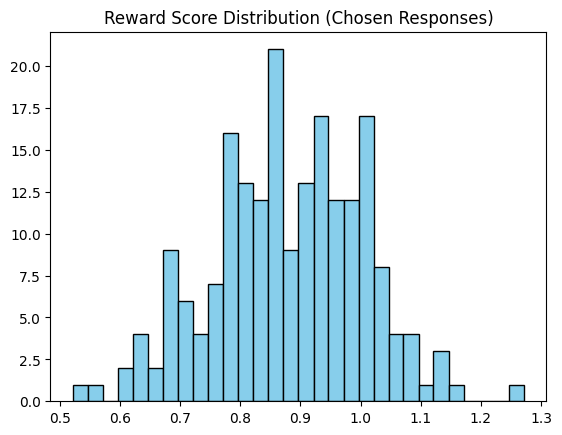

In [ ]:
#Scores distributions
def get_reward_scores(model, dataset, batch_size=8):
    model.eval()
    scores = []

    dataloader = DataLoader(dataset, batch_size=batch_size)

    for batch in dataloader:
        input_ids = torch.stack(batch['chosen_input_ids']).T.to("cuda")
        attention_mask = torch.stack(batch['chosen_attention_mask']).T.to("cuda")

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            batch_scores = outputs.logits.cpu().detach().numpy().flatten()
            scores.extend(batch_scores)

    return scores

chosen_scores = get_reward_scores(reward_model, eval_reward_ds)

#Results
import matplotlib.pyplot as plt
plt.hist(chosen_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Reward Score Distribution (Chosen Responses)')
plt.show()

In [ ]:
#Accuracy
def calculate_margins(model, dataset):
    model.eval()
    margins = []

    for i in range(len(dataset)):
        item = dataset[i]
        def get_single_score(ids, mask):
            ids_t = torch.tensor([ids]).to("cuda")
            mask_t = torch.tensor([mask]).to("cuda")
            return model(input_ids=ids_t, attention_mask=mask_t).logits.item()

        c_score = get_single_score(item['chosen_input_ids'], item['chosen_attention_mask'])
        r_score = get_single_score(item['rejected_input_ids'], item['rejected_attention_mask'])

        margins.append(c_score - r_score)

    return margins

margins = calculate_margins(reward_model, eval_reward_ds)
accuracy = sum(1 for m in margins if m > 0) / len(margins)
print(f"Reward Model Accuracy (Chosen > Rejected): {accuracy:.2%}")

Reward Model Accuracy (Chosen > Rejected): 39.00%


## Optimization with Proximal Policy Optimization (PPO)

In this final stage, we fine-tune a gpt-2 model using ppo and our previous reward model.

In [ ]:
#Clear gpu memory if needed
"""
if 'ppo_trainer' in locals(): del ppo_trainer
if 'reward_model' in locals(): del reward_model
if 'policy_model' in locals(): del policy_model

objs = ['ppo_trainer', 'trainer', 'reward_model', 'policy_model', 'base_model']
for obj_name in objs:
    if obj_name in globals():
        del globals()[obj_name]

gc.collect()
torch.cuda.empty_cache()

print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")"""

Allocated: 3672.48 MB
Reserved: 6082.00 MB


In [12]:
#Rename columns to match with expectaitons of ppo_trainer
train_ppo_ds = train_ppo_ds.rename_column("prompt_input_ids", "input_ids")
train_ppo_ds = train_ppo_ds.rename_column("prompt_attention_mask", "attention_mask")

eval_ppo_ds = eval_ppo_ds.rename_column("prompt_input_ids", "input_ids")
eval_ppo_ds = eval_ppo_ds.rename_column("prompt_attention_mask", "attention_mask")

train_ppo_ds.set_format(type='torch', columns=['input_ids', 'attention_mask'])
eval_ppo_ds.set_format(type='torch', columns=['input_ids', 'attention_mask'])

In [13]:
#Load models
from transformers import AutoModelForSequenceClassification, AutoTokenizer, GPT2Tokenizer, GenerationConfig, AutoModelForCausalLM
model_with_ppo = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
#ref_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
value_model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=1).to(device)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

reward_model = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/RLHF/reward_training/reward_model",
    num_labels=1, # Crucial: Reward models output 1 scalar
    torch_dtype=torch.float16 # Match your training precision
).to("cpu")

reward_model.config.pad_token_id = tokenizer.pad_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/RLHF/reward_training/reward_model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
#Config
config = PPOConfig(
    output_dir = "/content/drive/MyDrive/RLHF/ppo_training",
    learning_rate=1.0e-5,
    num_ppo_epochs=1,
    local_batch_size=1,
    mini_batch_size=1,
    kl_coef=0.05,
    fp16=True,
    gradient_accumulation_steps=4
)

<string>:167: FutureWarning: The `PPOConfig` is now located in `trl.experimental`. Please update your imports to `from trl.experimental.ppo import PPOConfig`. The current import path will be removed and no longer supported in TRL 0.29. For more information, see https://github.com/huggingface/trl/issues/4223.


In [15]:
#Trainer
ppo_trainer = PPOTrainer(config,
                         processing_class=tokenizer,
                         model = model_with_ppo,
                         ref_model = None,
                         value_model = value_model,
                         reward_model = reward_model,
                         train_dataset = train_ppo_ds,
                         eval_dataset = eval_ppo_ds
                         )
#Training
ppo_trainer.train()
ppo_trainer.save_model("drive/MyDrive/RLHF/ppo_training/model_with_ppo")

/tmp/ipython-input-282108430.py:2: FutureWarning: The `PPOTrainer` is now located in `trl.experimental`. Please update your imports to `from trl.experimental.ppo import PPOTrainer`. The current import path will be removed and no longer supported in TRL 0.29. For more information, see https://github.com/huggingface/trl/issues/4223.
  ppo_trainer = PPOTrainer(config,


===training policy===


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nathan-fig46 (nathan-fig46-universit-toulouse-capitole) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                           ┃ model response                                 ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Explain like I'm five years old: How can the    │                                                │ 1.25390625   │
│ same side of the moon always face earth?        │                                                │              │
│ Doesn't it rotate? The fact that the Chinese    │ The Chinese are also known to have been able   │              │
│ just landed on the dark side makes it seem      │ to use the moon's gravity to create a lunar    │              │
│ stranger.                                       │ eclipse.                                       │              │
│                                                 │                                                │              │
│                                                 │ The moon's gravity is also known to be a force │              │
│                                                 │ that can be used to create a lunar eclipse.    │              │
│                                                 │                                                │              │
│                                                 │ The moon's gravity is                          │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: As growing     │ ’’’’’’’’’’’’’’’’’’’’’’’’’’�                    │ 1.73828125   │
│ pains are a thing in adolescents, with bone,    │                                                │              │
│ joint and muscle aches, why isn’t that pain     │                                                │              │
│ also constantly present for infants and         │                                                │              │
│ toddlers who are growing at a much faster rate  │                                                │              │
│ with their bodies subject to greater            │                                                │              │
│ developmental stresses?                         │                                                │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ [Explain like I'm five years old] Why are       │                                                │ 1.197265625  │
│ battery capacities expressed in Ah              │                                                │              │
│ (Amperes-hour) and what does it mean, for       │ A: The battery capacity of a battery is        │              │
│ example, a AA battery that is 2500 mAh?         │ expressed in Ah (Amperes-hour) and the battery │              │
│                                                 │ capacity of a battery is expressed in Ah       │              │
│                                                 │ (Amperes-hour) and the battery capacity of a   │              │
│                                                 │ battery is expressed in Ah (Ampe               │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: Are people     │                                                │ 1.708984375  │
│ born lactose intolerant? And if so, how do      │                                                │              │
│ lactose intolerant babies drink their mothers   │ The answer is yes, but it's not clear how.     │              │
│ milk?                                           │                                                │              │
│                                                 │ The 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                           ┃ model response                                 ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Explain like I'm five years old: How can the    │                                                │ 1.294921875  │
│ same side of the moon always face earth?        │                                                │              │
│ Doesn't it rotate? The fact that the Chinese    │ The Chinese are also very good at predicting   │              │
│ just landed on the dark side makes it seem      │ the future. They have a great deal of          │              │
│ stranger.                                       │ confidence in the future, and they are very    │              │
│                                                 │ good at predicting the future. They are very   │              │
│                                                 │ good at predicting the future. They are very   │              │
│                                                 │ good at predicting the future. They            │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: As growing     │                                                │ 1.712890625  │
│ pains are a thing in adolescents, with bone,    │                                                │              │
│ joint and muscle aches, why isn’t that pain     │ ’’’’’’’’’’’’’’’’’’’’’’’’’�                     │              │
│ also constantly present for infants and         │                                                │              │
│ toddlers who are growing at a much faster rate  │                                                │              │
│ with their bodies subject to greater            │                                                │              │
│ developmental stresses?                         │                                                │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ [Explain like I'm five years old] Why are       │                                                │ 1.30859375   │
│ battery capacities expressed in Ah              │                                                │              │
│ (Amperes-hour) and what does it mean, for       │ I'm not sure.                                  │              │
│ example, a AA battery that is 2500 mAh?         │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                           ┃ model response                                 ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Explain like I'm five years old: How can the    │                                                │ 1.2373046875 │
│ same side of the moon always face earth?        │                                                │              │
│ Doesn't it rotate? The fact that the Chinese    │ I'm not sure how to explain this. I'm not sure │              │
│ just landed on the dark side makes it seem      │ how to explain this.                           │              │
│ stranger.                                       │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: As growing     │ ’                                              │ 1.6513671875 │
│ pains are a thing in adolescents, with bone,    │                                                │              │
│ joint and muscle aches, why isn’t that pain     │ ’                                              │              │
│ also constantly present for infants and         │                                                │              │
│ toddlers who are growing at a much faster rate  │ ’                                              │              │
│ with their bodies subject to greater            │                                                │              │
│ developmental stresses?                         │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’   

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                           ┃ model response                                 ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Explain like I'm five years old: How can the    │                                                │ 1.2373046875 │
│ same side of the moon always face earth?        │                                                │              │
│ Doesn't it rotate? The fact that the Chinese    │ I'm not sure how to explain this. I'm not sure │              │
│ just landed on the dark side makes it seem      │ how to explain this.                           │              │
│ stranger.                                       │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: As growing     │ ’                                              │ 1.6513671875 │
│ pains are a thing in adolescents, with bone,    │                                                │              │
│ joint and muscle aches, why isn’t that pain     │ ’                                              │              │
│ also constantly present for infants and         │                                                │              │
│ toddlers who are growing at a much faster rate  │ ’                                              │              │
│ with their bodies subject to greater            │                                                │              │
│ developmental stresses?                         │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’   

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                           ┃ model response                                 ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Explain like I'm five years old: How can the    │                                                │ 1.2373046875 │
│ same side of the moon always face earth?        │                                                │              │
│ Doesn't it rotate? The fact that the Chinese    │ I'm not sure how to explain this. I'm not sure │              │
│ just landed on the dark side makes it seem      │ how to explain this.                           │              │
│ stranger.                                       │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: As growing     │ ’                                              │ 1.6513671875 │
│ pains are a thing in adolescents, with bone,    │                                                │              │
│ joint and muscle aches, why isn’t that pain     │ ’                                              │              │
│ also constantly present for infants and         │                                                │              │
│ toddlers who are growing at a much faster rate  │ ’                                              │              │
│ with their bodies subject to greater            │                                                │              │
│ developmental stresses?                         │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’   

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                           ┃ model response                                 ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Explain like I'm five years old: How can the    │                                                │ 1.2373046875 │
│ same side of the moon always face earth?        │                                                │              │
│ Doesn't it rotate? The fact that the Chinese    │ I'm not sure how to explain this. I'm not sure │              │
│ just landed on the dark side makes it seem      │ how to explain this.                           │              │
│ stranger.                                       │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: As growing     │ ’                                              │ 1.6513671875 │
│ pains are a thing in adolescents, with bone,    │                                                │              │
│ joint and muscle aches, why isn’t that pain     │ ’                                              │              │
│ also constantly present for infants and         │                                                │              │
│ toddlers who are growing at a much faster rate  │ ’                                              │              │
│ with their bodies subject to greater            │                                                │              │
│ developmental stresses?                         │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’   

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                           ┃ model response                                 ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Explain like I'm five years old: How can the    │                                                │ 1.2373046875 │
│ same side of the moon always face earth?        │                                                │              │
│ Doesn't it rotate? The fact that the Chinese    │ I'm not sure how to explain this. I'm not sure │              │
│ just landed on the dark side makes it seem      │ how to explain this.                           │              │
│ stranger.                                       │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure how to explain this.              │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: As growing     │ ’                                              │ 1.6513671875 │
│ pains are a thing in adolescents, with bone,    │                                                │              │
│ joint and muscle aches, why isn’t that pain     │ ’                                              │              │
│ also constantly present for infants and         │                                                │              │
│ toddlers who are growing at a much faster rate  │ ’                                              │              │
│ with their bodies subject to greater            │                                                │              │
│ developmental stresses?                         │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’                                              │              │
│                                                 │                                                │              │
│                                                 │ ’   

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                           ┃ model response                                 ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Explain like I'm five years old: How can the    │                                                │ 1.3271484375 │
│ same side of the moon always face earth?        │                                                │              │
│ Doesn't it rotate? The fact that the Chinese    │ The Chinese are also very good at predicting   │              │
│ just landed on the dark side makes it seem      │ the future. They have a great deal of          │              │
│ stranger.                                       │ information about the future, and they can     │              │
│                                                 │ predict the future. They can predict the       │              │
│                                                 │ future, and they can predict the future.       │              │
│                                                 │                                                │              │
│                                                 │ The Chinese are also very good at              │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: As growing     │ ’’’’’’’’’’’’’’’’’’’’’’’’’’�                    │ 1.73828125   │
│ pains are a thing in adolescents, with bone,    │                                                │              │
│ joint and muscle aches, why isn’t that pain     │                                                │              │
│ also constantly present for infants and         │                                                │              │
│ toddlers who are growing at a much faster rate  │                                                │              │
│ with their bodies subject to greater            │                                                │              │
│ developmental stresses?                         │                                                │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ [Explain like I'm five years old] Why are       │                                                │ 1.30859375   │
│ battery capacities expressed in Ah              │                                                │              │
│ (Amperes-hour) and what does it mean, for       │ I'm not sure.                                  │              │
│ example, a AA battery that is 2500 mAh?         │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │     

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                           ┃ model response                                 ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Explain like I'm five years old: How can the    │                                                │ 1.3271484375 │
│ same side of the moon always face earth?        │                                                │              │
│ Doesn't it rotate? The fact that the Chinese    │ The Chinese are also very good at predicting   │              │
│ just landed on the dark side makes it seem      │ the future. They have a great deal of          │              │
│ stranger.                                       │ information about the future, and they can     │              │
│                                                 │ predict the future. They can predict the       │              │
│                                                 │ future, and they can predict the future.       │              │
│                                                 │                                                │              │
│                                                 │ The Chinese are also very good at              │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: As growing     │ ’’’’’’’’’’’’’’’’’’’’’’’’’’�                    │ 1.73828125   │
│ pains are a thing in adolescents, with bone,    │                                                │              │
│ joint and muscle aches, why isn’t that pain     │                                                │              │
│ also constantly present for infants and         │                                                │              │
│ toddlers who are growing at a much faster rate  │                                                │              │
│ with their bodies subject to greater            │                                                │              │
│ developmental stresses?                         │                                                │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ [Explain like I'm five years old] Why are       │                                                │ 1.30859375   │
│ battery capacities expressed in Ah              │                                                │              │
│ (Amperes-hour) and what does it mean, for       │ I'm not sure.                                  │              │
│ example, a AA battery that is 2500 mAh?         │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │                                                │              │
│                                                 │ I'm not sure.                                  │              │
│                                                 │     

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                           ┃ model response                                 ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Explain like I'm five years old: How can the    │                                                │ 1.3271484375 │
│ same side of the moon always face earth?        │                                                │              │
│ Doesn't it rotate? The fact that the Chinese    │ The Chinese are also very good at predicting   │              │
│ just landed on the dark side makes it seem      │ the future. They have a great deal of          │              │
│ stranger.                                       │ information about the future, and they can     │              │
│                                                 │ predict the future. They can predict the       │              │
│                                                 │ future, and they can predict the future.       │              │
│                                                 │                                                │              │
│                                                 │ The Chinese are also very good at              │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: As growing     │ ’’’’’’’’’’’’’’’’’’’’’’’’’’�                    │ 1.73828125   │
│ pains are a thing in adolescents, with bone,    │                                                │              │
│ joint and muscle aches, why isn’t that pain     │                                                │              │
│ also constantly present for infants and         │                                                │              │
│ toddlers who are growing at a much faster rate  │                                                │              │
│ with their bodies subject to greater            │                                                │              │
│ developmental stresses?                         │                                                │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ [Explain like I'm five years old] Why are       │                                                │ 1.10546875   │
│ battery capacities expressed in Ah              │                                                │              │
│ (Amperes-hour) and what does it mean, for       │ The answer is that the battery is not          │              │
│ example, a AA battery that is 2500 mAh?         │ expressed in Ah (Amperes-hour) and the battery │              │
│                                                 │ is not expressed in Amperes-hour.              │              │
│                                                 │                                                │              │
│                                                 │ The battery is not expressed in Ah             │              │
│                                                 │ (Amperes-hour) and the battery is              │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: Are people     │                                                │ 1.59375      │
│ born lactose intolerant? And if so, how do      │                                                │              │
│ lactose intolerant babies drink their mothers   │ "I think it's important to understand that     │              │
│ milk?                                           │ there are many different types of lactose      │              │
│                                                 │ into

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                           ┃ model response                                 ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ Explain like I'm five years old: How can the    │                                                │ 1.3271484375 │
│ same side of the moon always face earth?        │                                                │              │
│ Doesn't it rotate? The fact that the Chinese    │ The Chinese are also very good at predicting   │              │
│ just landed on the dark side makes it seem      │ the future. They have a great deal of          │              │
│ stranger.                                       │ information about the future, and they can     │              │
│                                                 │ predict the future. They can predict the       │              │
│                                                 │ future, and they can predict the future.       │              │
│                                                 │                                                │              │
│                                                 │ The Chinese are also very good at              │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: As growing     │ ’’’’’’’’’’’’’’’’’’’’’’’’’’�                    │ 1.73828125   │
│ pains are a thing in adolescents, with bone,    │                                                │              │
│ joint and muscle aches, why isn’t that pain     │                                                │              │
│ also constantly present for infants and         │                                                │              │
│ toddlers who are growing at a much faster rate  │                                                │              │
│ with their bodies subject to greater            │                                                │              │
│ developmental stresses?                         │                                                │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ [Explain like I'm five years old] Why are       │                                                │ 1.10546875   │
│ battery capacities expressed in Ah              │                                                │              │
│ (Amperes-hour) and what does it mean, for       │ The answer is that the battery is not          │              │
│ example, a AA battery that is 2500 mAh?         │ expressed in Ah (Amperes-hour) and the battery │              │
│                                                 │ is not expressed in Amperes-hour.              │              │
│                                                 │                                                │              │
│                                                 │ The battery is not expressed in Ah             │              │
│                                                 │ (Amperes-hour) and the battery is              │              │
├─────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────┤
│ Explain like I'm five years old: Are people     │                                                │ 1.5625       │
│ born lactose intolerant? And if so, how do      │                                                │              │
│ lactose intolerant babies drink their mothers   │ "I think it's important to understand that     │              │
│ milk?                                           │ there are many different types of lactose      │              │
│                                                 │ into

In [ ]:
model_with_ppo.save_pretrained("drive/MyDrive/RLHF/ppo_training/model_with_ppo")

### Metrics

The metrics are available in the wandb environment.

## Generation of a sample output from the optimized model:

In [ ]:
query_txt = "The sky is blue because"
query_tensor = tokenizer.encode(query_txt, return_tensors="pt").to(model_with_ppo.device)

generation_kwargs = {
    "min_length": -1,
    "top_k": 0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 20,
}

#Generate model response
response_tensor = model_with_ppo.generate(query_tensor, **generation_kwargs)
response_txt = tokenizer.decode(response_tensor[0])

print("Query:", query_txt)
print("Generated Response:", response_txt)


Query: The sky is blue because
Generated Response: The sky is blue because there aren't crime scenes. And fish ones. And anybody has a boat. So you know you


In [ ]:
ref_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
#Queries to test
queries = [
    "This morning I went to the ",
    "The best way to learn something new is ",
    "A perfect vacation destination could be ",
    "For dinner tonight, I am planning to make ",
    "One of the most fascinating historical events is ",
    "The importance of exercise in daily life is ",
    "My favorite childhood memory is ",
    "The technology of the future might include ",
    "A great way to spend a weekend is ",
    "The secret to happiness might be found in "
]

generation_kwargs = {
    "do_sample": True,
    "top_p": 0.95,
    "top_k": 50,
    "temperature": 0.7,
    "max_new_tokens": 30,
    "pad_token_id": tokenizer.eos_token_id,
    "repetition_penalty": 1.2
}


ref_model.eval()
model_with_ppo.eval()


for i, query_txt in enumerate(queries):
    inputs = tokenizer(query_txt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        #Base Model
        base_tokens = ref_model.generate(**inputs, **generation_kwargs)
        base_resp = tokenizer.decode(base_tokens[0], skip_special_tokens=True)[len(query_txt):].strip()

        #RLHF Model
        ppo_tokens = model_with_ppo.generate(**inputs, **generation_kwargs)
        ppo_resp = tokenizer.decode(ppo_tokens[0], skip_special_tokens=True)[len(query_txt):].strip()

    # Format Output Line-by-Line
    print(f"--- {i+1} ---")
    print(f"PROMPT:    {query_txt}")
    print(f"BASE SFT:  {base_resp}")
    print(f"RLHF PPO:  {ppo_resp}")
    print("-" * 60)
    print() # Empty line for readability

QUERY                                    | BASE MODEL (SFT)                         | RLHF OPTIMIZED                          
-----------------------------------------------------------------------------------------------------------------------------
--- TEST CASE 1 ---
PROMPT:    This morning I went to the 
BASE SFT:  University of Manchester in London and found out that they have an interesting paper on this. They said it is a very good study but its important for
RLHF PPO:  【World of Ice and Fire】[1] store in my class, where all stores are open. It was like a world beyond any other bookstore
------------------------------------------------------------

--- TEST CASE 2 ---
PROMPT:    The best way to learn something new is 
BASE SFT:  to create a list of things you will like about yourself. In this example, I am writing my life story and doing it in English instead (
RLHF PPO:  to get as much practice in it. You'll find that you will be able to do so by working with your own persona